# Problem 1 - Model Predictive Control

Creates the Quadrotor object and loads in the animation code.

**Re-run this block anytime you make change to `quadrotor.py`.**

In [1]:
%matplotlib inline

"""
Simulate quadrotor
"""

import numpy as np
from math import sin, cos, pi
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import importlib

from quad_sim import simulate_quadrotor

# Need to reload the module to use the latest code
import quadrotor
importlib.reload(quadrotor)
from quadrotor import Quadrotor

"""
Load in the animation function
"""
import create_animation
importlib.reload(create_animation)
from create_animation import create_animation

# Weights of LQR cost
R = np.eye(2);
Q = np.diag([10, 10, 1, 1, 1, 1]);
Qf = Q;

# End time of the simulation
tf = 10;

# Construct our quadrotor controller 
quadrotor = Quadrotor(Q, R, Qf);

/shared-libs/python3.8/py/lib/python3.8/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.17.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
A=-1*np.ones((2,3))
A[0,0] =1
A[0,1]=A[1,1]=0
A

array([[ 1.,  0., -1.],
       [-1.,  0., -1.]])

## Simulate the quadrotor using MPC as the controller


In [3]:
# Set quadrotor's initial state and simulate
x0 = np.array([0.5, 0.5, 0, 1, 1, 0])
x, u, t = simulate_quadrotor(x0, tf, quadrotor)

anim, fig = create_animation(x, tf)
plt.close()
anim

[4.90591949 4.90553329]


In [4]:
x

array([[ 5.00000000e-01,  5.00000000e-01,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 5.10000000e-01,  5.10000000e-01,  0.00000000e+00,
         1.00000000e+00,  9.60382675e-01,  8.80754196e-02],
       [ 5.20000000e-01,  5.19603827e-01,  8.80754196e-04,
         1.00000000e+00,  9.21429441e-01,  1.69251857e-01],
       ...,
       [ 8.31081019e-04,  6.23266094e-04, -6.11204859e-05,
        -1.49652012e-03, -1.36708689e-03, -6.15469915e-04],
       [ 8.16115818e-04,  6.09595226e-04, -6.72751851e-05,
        -1.49052332e-03, -1.35262121e-03, -6.00198215e-04],
       [ 8.01210585e-04,  5.96069013e-04, -7.32771672e-05,
        -1.48392264e-03, -1.33809371e-03, -5.84750266e-04]])

## Simulate the quadrotor using LQR as the controller (Already implemented)

In [5]:
Q

array([[10,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  1]])

In [6]:
# Set quadrotor's initial state and simulate
x0 = np.array([0.5, 0.5, 0, 1, 1, 0])
x, u, t = simulate_quadrotor(x0, tf, quadrotor, False)

anim, fig = create_animation(x, tf)
plt.close()
anim

[4.89732095 4.8974893 ]


# Problem 2 - Operational Space Control

### Start Meshcat Visualizer
Open the visualizer by clicking on the url in the output of this cell.

In [7]:
from pydrake.all import StartMeshcat

meshcat = StartMeshcat()

Installing NginX server for MeshCat on Deepnote...
INFO:drake:Meshcat listening for connections at https://e97ca194-26ab-4551-8723-804bf810d4a5.deepnoteproject.com/7000/


### Setup the simulation

Drake simulations are built as block diagrams, similarly to Simulink or LabVIEW, except the blocks (systems) are defined programatically rather than graphically. 

This cell creates a Drake Diagram, and adds the system blocks for the OSC, footstep planner, and a simulated planar walker. You can change the OSC gains and the desired walking speed, then run this cell to view the diagram it creates. The next cell runs the simulation, which you can view in meshcat.

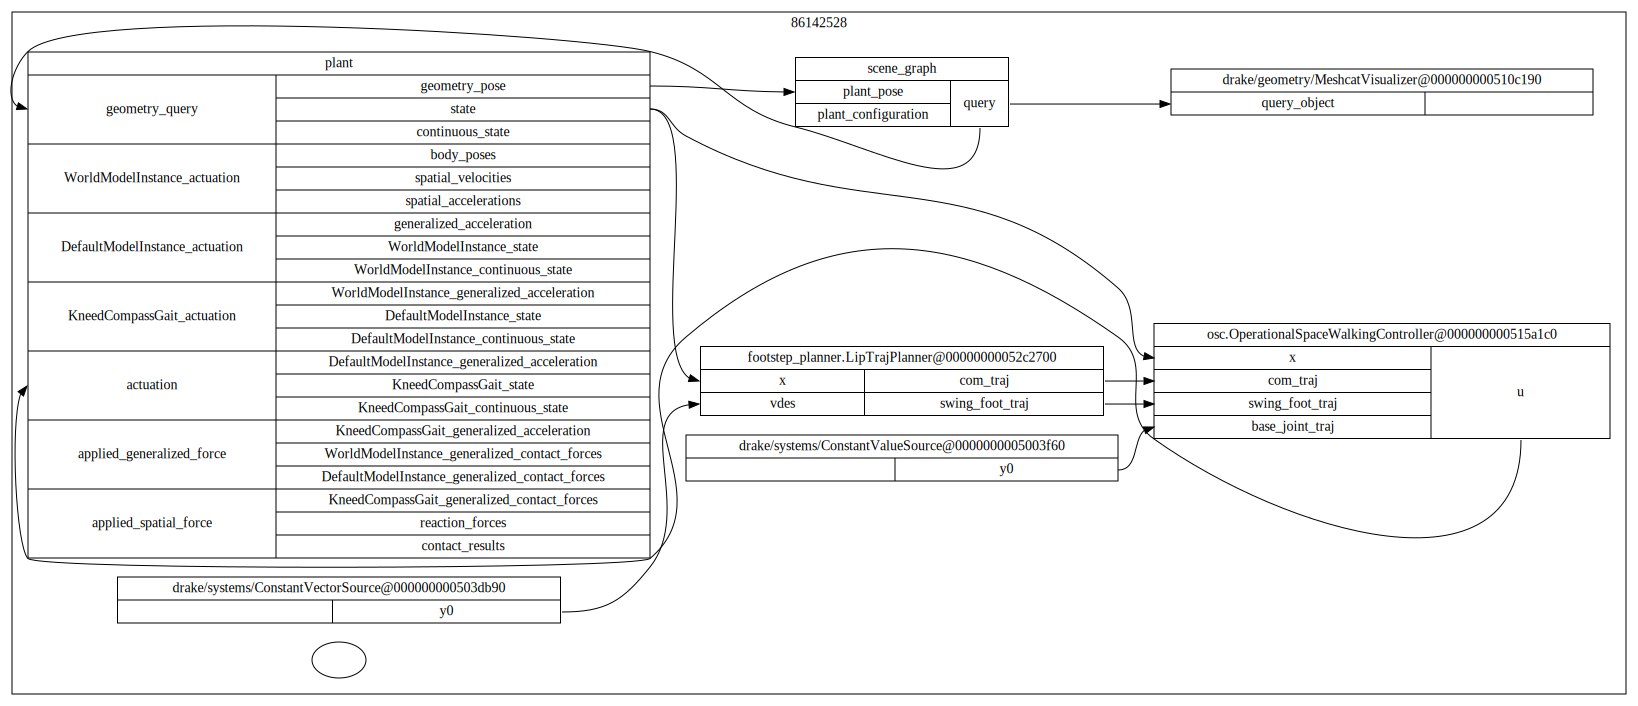

In [8]:
import pydot
import numpy as np
from IPython.display import SVG, display

from pydrake.all import Simulator, DiagramBuilder, AddMultibodyPlantSceneGraph,\
                        Parser, RigidTransform, MeshcatVisualizer, MeshcatVisualizerParams, \
                        ConstantVectorSource, ConstantValueSource, PiecewisePolynomial,\
                        AbstractValue, HalfSpace, CoulombFriction
import footstep_planner
import osc
import importlib
importlib.reload(osc)
importlib.reload(footstep_planner)
from osc import OperationalSpaceWalkingController, OscGains

# Build the block diagram for the simulation
builder = DiagramBuilder()

# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(
    plant.world_body(), 
    X_WG, HalfSpace(), 
    "collision", 
    CoulombFriction(1.0, 1.0)
)
parser = Parser(plant)
parser.AddModelFromFile("planar_walker.urdf")
plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()


# Build the controller diagram
Kp = np.diag([100, 0, 100])
Kd = np.diag([10, 0, 10])
W = np.diag([1, 0, 1])

Wcom = np.zeros((3,3))
Wcom[2,2] = 1

gains = OscGains(
        Kp, Kd, Wcom,
        Kp, Kd, W,
        np.eye(1), np.eye(1), np.eye(1),
        0.00001
    )


# TODO: Adjust target wlaking speed here
walking_speed = 0.5 # walking speed in m/s

osc = builder.AddSystem(OperationalSpaceWalkingController(gains))
planner = builder.AddSystem(footstep_planner.LipTrajPlanner())
speed_src = builder.AddSystem(ConstantVectorSource(np.array([walking_speed])))
base_traj_src = builder.AddSystem(
    ConstantValueSource(AbstractValue.Make(PiecewisePolynomial(np.zeros(1,))))
)

# Wire planner inputs 
builder.Connect(plant.get_state_output_port(), 
                planner.get_state_input_port())
builder.Connect(speed_src.get_output_port(), 
                planner.get_walking_speed_input_port())

# Wire OSC inputs
builder.Connect(plant.get_state_output_port(), 
                osc.get_state_input_port()) 
builder.Connect(planner.get_swing_foot_traj_output_port(), 
                osc.get_traj_input_port("swing_foot_traj"))
builder.Connect(planner.get_com_traj_output_port(), 
                osc.get_traj_input_port("com_traj"))
builder.Connect(base_traj_src.get_output_port(), 
                osc.get_traj_input_port("base_joint_traj"))

# Add the visualizer
vis_params = MeshcatVisualizerParams(publish_period=0.01)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

# Wire OSC to plant
builder.Connect(osc.get_output_port(), 
                plant.get_actuation_input_port())

#simulate
diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

### Run the simulation
After you have run the above block, you can actually run the simulation with this one.

In [9]:
# NOTE - if you make changes, you should re-run the cell above this one

sim_time = 10.0
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(1)

# Set the robot state
plant_context = diagram.GetMutableSubsystemContext(
    plant, simulator.get_mutable_context())
q = np.zeros((plant.num_positions(),))
q[1] = 0.8
theta = -np.arccos(q[1])
q[3] = theta
q[4] = -2 * theta
q[5] = theta
q[6] = -2 * theta
plant.SetPositions(plant_context, q)

# Simulate the robot
simulator.AdvanceTo(sim_time)

In [10]:
plant.num_velocities()


7

In [11]:
gains.w_vdot


1e-05

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e97ca194-26ab-4551-8723-804bf810d4a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>